#### This is for Program-level forecasting  
Use year=2016 to train, then predict on year=2017 data

In [361]:
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
#from calcRMSE import calcRMSE
import numpy as np
from getConfig import getConfig
from prepData import prepData
from getDataH2O import getData

In [362]:
h2o.no_progress()
h2o.init(port=54321)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,8 hours 9 mins
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.2
H2O cluster version age:,1 month and 24 days
H2O cluster name:,tbrownex
H2O cluster total nodes:,1
H2O cluster free memory:,805 Mb
H2O cluster total cores:,1
H2O cluster allowed cores:,1
H2O cluster status:,"locked, healthy"


In [363]:
def buildModel(parms):
    numTrees = parms[0]
    leafSize = parms[1]
    depth    = parms[2]
    return H2ORandomForestEstimator(
        model_id="rf_v1",
        ntrees=numTrees,
        min_rows=leafSize,
        max_depth=depth,
        stopping_rounds=4)

In [364]:
def showVariables(model):
    results = model._model_json['output']['variable_importances'].as_data_frame()
    pct = results["scaled_importance"].round(2)
    var = results["variable"]
    tom = zip(var, pct)
    for x in tom:
        print(x)

In [365]:
def mapErrors(vizData):
    import matplotlib.pyplot as plt
    pgms    = [x[0] for x in vizData]
    actuals = [x[1] for x in vizData]
    errs    = [x[2] for x in vizData]
    plt.xlabel("Prediction Error")
    plt.ylabel("Actual Hours")
    plt.scatter(errs, actuals, s=6, marker="o")
    plt.title("Program Actuals vs Predicted Pct Error")
    plt.grid()
    plt.savefig(fname="/home/tbrownex/BoeingResults.jpeg")
    #plt.show()

In [366]:
def evaluate(test, preds):
    preds = preds.as_data_frame().as_matrix()
    results = test[["Program", "Actual"]].as_data_frame()
    results["Pred"] = preds
    
    results.set_index("Program", inplace=True)
    grp = results.groupby(level=0)

    score = 0
    vizData = []
    for x in grp:
        pred = x[1]["Pred"].sum()
        act = x[1]["Actual"].sum()
        error = abs(pred - act) / act
        score += error
        if abs(error) < 2:
            if act < 100000:
                vizData.append((x[0], act, error))
    mape = score/len(grp)
    mapErrors(vizData)
    return mape

In [367]:
def recordResults(p, mape):
    trees = p[0]
    leaf = p[1]
    depth = p[2]
    rec = str(trees) +","+ str(leaf) +","+ str(depth)+","+ str(mape)+"\n"
    scores.write(rec)

In [368]:
def process(p, dataDict):
    model = buildModel(p)
    model.train(features, y=label, training_frame=dataDict["train"], validation_frame=dataDict["val"])
    #showVariables(model)
    preds = model.predict(dataDict["test"])
    mape = evaluate(dataDict["test"], preds)
    recordResults(p,mape)

In [369]:
config = getConfig()
df = getData(config)
dataDict = prepData(df, config)

# H2O requires the names of the columns to be used as features and labels
features = dataDict["train"].col_names[:-1]
label    = dataDict["train"].col_names[-1]

/home/tbrownex/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/tbrownex/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


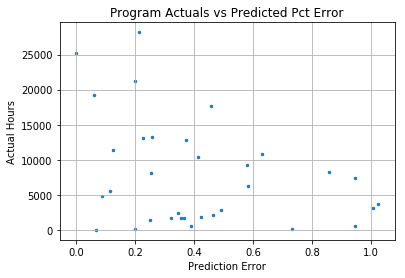

In [370]:
parms = []
numTrees = [1200]
leafSize = [2]
depth    = [26]
for t in numTrees:
    for s in leafSize:
        for d in depth:
            parm = (t,s, d)
            parms.append(parm)

loops=1
with open("/home/tbrownex/scores.csv", "w") as scores:
    for n in range(loops):
        for p in parms:
            process(p, dataDict)